In [1]:
import os
import re
import math
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster

from tqdm.auto import tqdm
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
from matplotlib.patches import Rectangle

from utils.stop_detector import StopDetector
from utils.cluster import GPS_DBScan

In [2]:
LAT_DEFINE = 13.741163338261524
LON_DEFINE = 100.64205151814542

ZOOM_START = 10

In [3]:
gps_data_dir = 'E:/data/gps'
road_data_dir = 'E:/data/road'
stop_data_dir = 'E:/data/stop'

In [4]:
tqdm.pandas(desc='working : ')

# Explore gps data

## Function load data

### - load GPS data
- **Columns**
  - time_stamp => เป็นวันเวลา
  - unit_id => เป็น id ของรถ
  - lat => เป็นค่า latitude
  - lon => เป็นค่า longitude
  - speed => เป็นค่าความเร็ว หน่วยเป็น km/h
  - unit_type => เป็นชนิดของรถ
    - 1 = รถโดยสารประจำทาง
    - 3 = รถโดยสารไม่ประจำทาง
    - 4 = รถโดยสารส่วนบุคคล
    - 5,8,9  = รถบรรทุกส่วนบุคคล
    - 6,7 = รถบรรทุกไม่ประจำทาง

In [5]:
# df_gps = pd.read_csv(gps_data_dir + '/2019/2019-03/2019-03-01_00.zip')
# df_gps.head()

### - load road data
- **Columns**
  - rid => หมายเลขสายถนน
  - rd => เลขถนน
  - km
  - ptype => ชนิดหลัก
  - lat, lon => ข้อมูลพิกัดแบบละเอียด
  - latx, lonx => ข้อมูลพิกัด ทศนิยม 3 ตำแหน่ง
  - angle => องศาของถนน 

In [6]:
# df_road = pd.read_csv(road_data_dir + '/roaddb.csv')
# df_road.head()

### - function load data

In [5]:
def clean_df_tmp(df_tmp):
    """
    Function for clean dataframe by cleaning condition.
    """
    unit_type = df_tmp['unit_type'].isin([6, 7])

    df_tmp = df_tmp[unit_type].reset_index(drop=True)
    return df_tmp

def load_gps_data():
    """
    Function for load and merge dataframes.
    """
    years_list = ['2019']
    months_list = ['03']
    days_list = ['01']
    df_list = []

    for year in years_list:
        for month in months_list:
            # get list filename in the folder path.
            file_names = os.listdir(gps_data_dir + f"/{year}/{year}-{month}/")
            for day in days_list:
                amount_day = 0
                for file_name in file_names:
                    file_name_part = re.split('-|_', file_name)
                    if len(file_name_part) > 2:
                        # select the day we chose from filename.
                        if file_name_part[2] == day:
                            _tmp = pd.read_csv(gps_data_dir + f"/{year}/{year}-{month}/" + file_name, compression='zip', parse_dates=['time_stamp'])
                            _tmp = clean_df_tmp(_tmp)
                            df_list.append(_tmp)
                            amount_day += 1
                            del _tmp

                    # the data collected was split into 8 sessions per day.
                    if amount_day > 7:
                        break
    
    df_gps = pd.concat(df_list, axis='rows', ignore_index=True)
    return df_gps

def get_road_data(rd):
    df_road = pd.read_csv(road_data_dir + '/roaddb.csv')
    df_road = df_road[df_road['rd'] == rd].reset_index(drop=True)
    return df_road

## Find interesting road for use in project

### - function for find interesting road

In [7]:
def get_road_dict(df_road):
    road_list = []
    df_road['coor'] = df_road.progress_apply(lambda row: f"{row['latx']:.3f}, {row['lonx']:.3f}", axis='columns')
    for rd in df_road['rd'].unique():
        coors = df_road[df_road['rd'] == rd]['coor'].to_list()
        road_dict = {
            'rd': rd,
            'coor_list': coors,
        }
        road_list.append(road_dict)
    return road_list

def get_road_interest(df_gps, road_list):
    df_gps = df_gps[df_gps['unit_type'].isin([6, 7])].reset_index(drop=True)
    df_gps = df_gps.drop_duplicates(subset=['unit_id']).reset_index(drop=True)
    df_gps['coor'] = df_gps.progress_apply(lambda row: f"{row['lat']:.3f}, {row['lon']:.3f}", axis='columns')
    for idx in range(len(road_list)):
        count_car = len(df_gps[df_gps['coor'].isin(road_list[idx]['coor_list'])])
        road_list[idx]['count_car'] = count_car

    return road_list

def find_road_interest():
    df_road = pd.read_csv(road_data_dir + '/roaddb.csv')
    df_gps = pd.read_csv(gps_data_dir + '/2019/2019-03/2019-03-08_21.zip', compression='zip')

    try:
        road_list = get_road_dict(df_road)
        road_list = get_road_interest(df_gps, road_list)

        # sort 'count_car' from highest to lowest.
        road_list.sort(key=sort_count, reverse=True)
    except:
        print(f"Error for find road interest")
    finally:
        # clear data in memory
        del df_road
        del df_gps

    return road_list

def sort_count(d):
    """
    function get value for sort list
    """
    return d['count_car']

### - find interesting road

In [8]:
road_list = find_road_interest()

working : 100%|██████████| 100106/100106 [00:01<00:00, 94507.46it/s]


In [9]:
# show top 10 road number have trucks
for idx in range(10):
    print(f"{road_list[idx]['rd']} : {road_list[idx]['count_car']}")

1 : 2483
4 : 2424
2 : 2247
9 : 1456
41 : 1185
7 : 1134
3901 : 1049
3902 : 1037
304 : 750
32 : 723


## Find support point in data

### - function for get amount of truck at point

In [10]:
def get_road_dict_select(df_road):
    road_list_select = []
    df_road['coor'] = df_road.progress_apply(lambda row: f"{row['latx']:.3f}, {row['lonx']:.3f}", axis='columns')
    for rd in [1, 2, 4, 7, 9, 32, 41, 304, 3901, 3902]:
        coors = df_road[df_road['rd'] == rd]['coor'].to_list()
        road_dict_select = {
            'rd': rd,
            'coor_list': coors,
        }
        road_list_select.append(road_dict_select)
    return road_list_select

def get_point_amount(df_gps, road_list_select):
    point_list = []
    df_gps['coor'] = df_gps.progress_apply(lambda row: f"{row['lat']:.3f}, {row['lon']:.3f}", axis='columns')
    for idx in tqdm(range(len(road_list_select))):
        _tmp = df_gps[df_gps['coor'].isin(road_list_select[idx]['coor_list'])].reset_index(drop=True)
        for coor in road_list_select[idx]['coor_list']:
            _vehicle = _tmp[_tmp['coor'] == coor].reset_index(drop=True)
            _vehicle = _vehicle.drop_duplicates(subset=['unit_id']).reset_index(drop=True)
            point_dict = {
                'rd': road_list_select[idx]['rd'],
                'coor': coor,
                'amount': len(_vehicle)
            }
            point_list.append(point_dict)
            del _vehicle
        del _tmp
    return point_list
        

def find_point():
    df_road = pd.read_csv(road_data_dir + '/roaddb.csv')
    df_gps = load_gps_data()

    try:
        road_list_select = get_road_dict_select(df_road)
        point_list = get_point_amount(df_gps, road_list_select)
        df_point = pd.DataFrame(point_list)
    except:
        print(f"Error for find point")
    finally:
        # clear data in memory
        del df_road
        del df_gps
        del road_list_select
        del point_list

    return df_point

### - visualize gps

In [11]:
def plot_gps(lat, lon, popup, tooltip, mean, amount):
    if popup is None:
        popup = ['Some detail'] * len(lat)

    map = folium.Map(location=[LAT_DEFINE, LON_DEFINE], zoom_start=ZOOM_START)
    for _lat, _lon, _popup, _tooltip, _amount in zip(lat, lon, popup, tooltip, amount):
        if _amount > mean:
            folium.CircleMarker(
                location = [_lat, _lon],
                radius = 6,
                popup = _popup,
                color = 'blue',
                fill = True,
                fill_color = 'blue',
                fill_opacity = 0.7,
                tooltip = _tooltip
            ).add_to(map)

    display(map)

def plot_road_filter(df_point, rd):
    df_tmp = df_point[df_point['rd'] == rd].reset_index(drop=True).copy()
    # df_tmp = df_tmp[df_tmp['amount'] > int(df_tmp['amount'].mean())].reset_index(drop=True)
    df_tmp['lat'] = df_tmp.apply(lambda row: float(row['coor'].split(',')[0]), axis=1)
    df_tmp['lon'] = df_tmp.apply(lambda row: float(row['coor'].split(',')[1]), axis=1)
    df_tmp = df_tmp.drop(['rd', 'coor', 'amount'], axis=1)
    
    print(len(df_tmp))

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.scatter(x=df_tmp['lon'], y=df_tmp['lat'], s=1, alpha=1, c='steelblue')
    plt.show()

def visualize_point(df_point):
    mean_list = df_point.groupby(['rd']).mean()['amount'].to_list()
    idx = 0

    for rd in [1, 2, 4, 7, 9, 32, 41, 304, 3901, 3902]:
        _tmp = df_point[df_point['rd'] == rd].reset_index(drop=True)

        lat = _tmp['coor'].apply(lambda row: float(row.split(',')[0])).to_list()
        lon = _tmp['coor'].apply(lambda row: float(row.split(',')[1])).to_list()
        popup = _tmp['rd'].to_list()
        amount = _tmp['amount'].to_list()
        tooltip = _tmp['amount'].apply(lambda row: f"amount: {row}").to_list()
        plot_gps(lat, lon, popup, tooltip, mean_list[idx], amount)
        idx += 1
    

### - find amount of truck at point

In [ ]:
df_point = find_point()

In [8]:
df_point = df_point[df_point['amount'] > 0].reset_index(drop=True)
df_point.groupby(['rd']).mean()

amount
rd             
1      6.845313
2      7.833971
4      6.618455
7     17.401567
9     11.042042
32     6.222008
41     6.487973
304    6.735426
3901  11.403046
3902  12.066000

In [ ]:
# visualize_point(df_point)

## Clustering group of data

### - DBscan

find eps for DBScan

In [42]:
def get_eps_with_NN(df_point, rd, n_neighbors):
    # init dataframe for find epsilon
    df_neighbors = df_point.copy()
    df_neighbors = df_neighbors[df_neighbors['rd'] == rd].reset_index(drop=True)
    df_neighbors = df_neighbors[df_neighbors['amount'] > int(df_neighbors['amount'].mean())].reset_index(drop=True)
    df_neighbors['lat'] = df_neighbors.apply(lambda row: float(row['coor'].split(',')[0]), axis=1)
    df_neighbors['lon'] = df_neighbors.apply(lambda row: float(row['coor'].split(',')[1]), axis=1)
    df_neighbors = df_neighbors.drop(['rd', 'coor', 'amount'], axis=1)

    # train NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=n_neighbors)
    neighbors_fit = neighbors.fit(df_neighbors)
    distances, _ = neighbors_fit.kneighbors(df_neighbors)

    # sort value for plot
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    # plot
    plt.plot(distances[:])
    plt.show()

    return df_neighbors

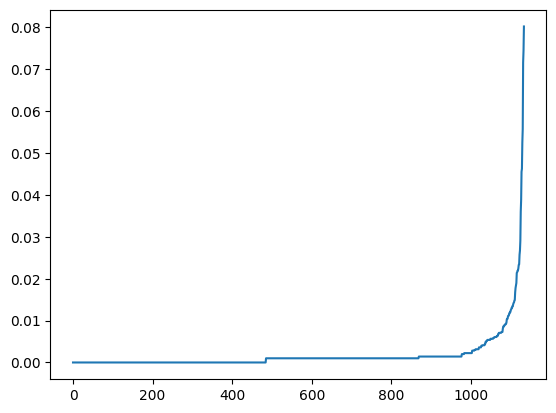

In [84]:
df_neighbors = get_eps_with_NN(df_point, 1, 6)

DBScan

In [37]:
def plot_dbscan(df_tmp, labels, df_road):
    # init color for plot
    customPalette = ['#36382E', '#FF206E', '#E5C687', '#41EAD4', '#5C80BC', '#FB8B24', '#04A777', '#7E8D85', '#B3BFB8', '#6F8695']

    plt.figure(figsize=(20, 15))

    plt.scatter(
        x=df_road['lon'],
        y=df_road['lat'],
        s=0.5,
        alpha=0.5
    )

    for i, label in enumerate(labels):
        plt.scatter(
            x=df_tmp[df_tmp['label'] == label]['lon'],
            y=df_tmp[df_tmp['label'] == label]['lat'],
            color=customPalette[i % len(customPalette)],
            alpha=1
        )

        plt.annotate(
            label,
            df_tmp.loc[df_tmp['label'] == label, ['lon', 'lat']].mean(),
            horizontalalignment='center',
            verticalalignment='center',
            size=10,
            weight='bold',
            color='white',
            backgroundcolor=customPalette[i % len(customPalette)]
        )

    plt.show()

def get_dbscan_value_counts(df_dbscan):
    print(df_dbscan['label'].value_counts()[:10])

def dbscan(df_neighbors, eps, min_samples, df_road):
    df_tmp = df_neighbors.copy()
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df_tmp)

    df_tmp['label'] = clustering.labels_

    idx_noise = df_tmp[df_tmp['label'] == -1].index
    df_tmp = df_tmp.drop(idx_noise).reset_index(drop=True)

    labels = list(set(df_tmp['label'].to_list()))
    plot_dbscan(df_tmp, labels, df_road)
    
    return df_tmp

def find_cluster(df_neighbors, rd, eps, min_samples):
    df_road = get_road_data(rd)
    df_dbscan = dbscan(df_neighbors, eps, min_samples, df_road)

    del df_road

    return df_dbscan

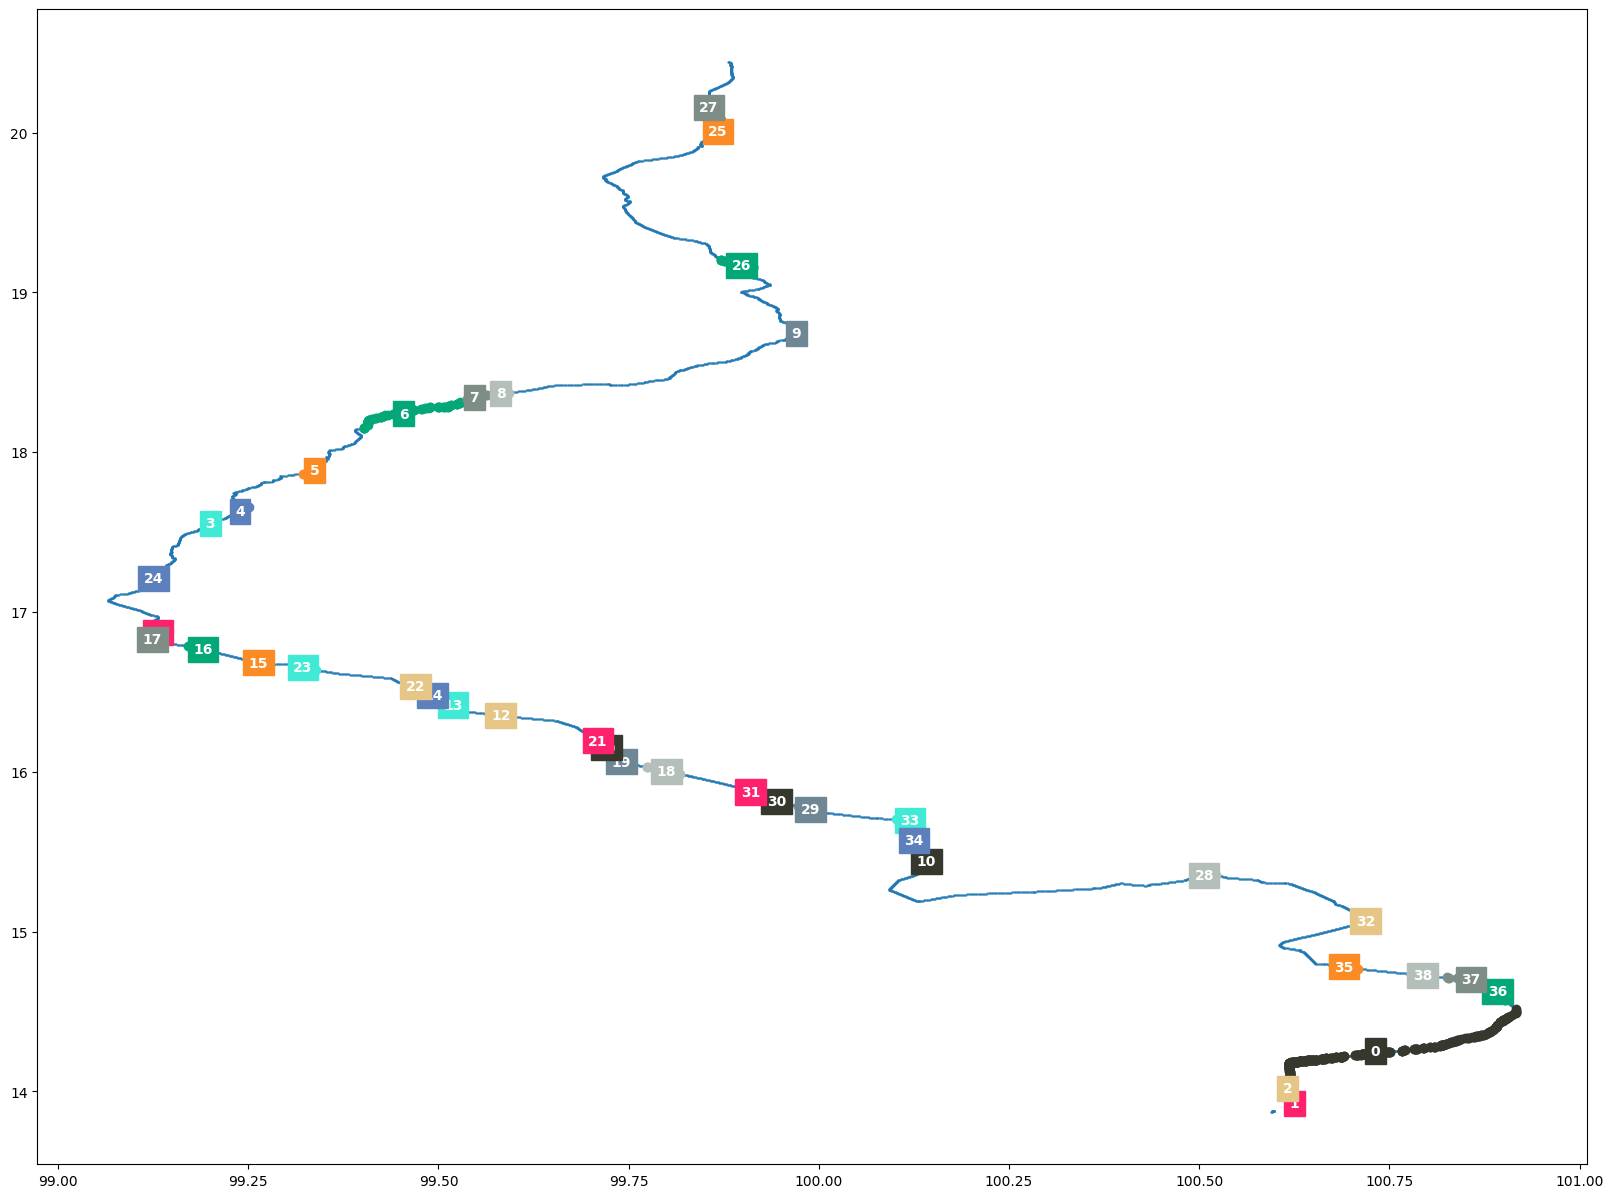

In [189]:
df_dbscan = find_cluster(df_neighbors, 1, 0.02, 6)

In [190]:
get_dbscan_value_counts(df_dbscan)

0     346
6      69
10     45
36     42
2      34
34     34
11     32
26     30
18     26
29     19
Name: label, dtype: int64


### - K-mean

find k in kmean by Elbow Methd

In [ ]:
def plot_k_kmean(distortions, k):
    fig, ax = plt.subplots()
    ax.plot(range(1, len(distortions) + 1), distortions)
    ax.axvline(k, ls='--', color="red", label="k = "+str(k))
    ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")
    ax.legend()
    ax.grid(True)
    plt.show()

def get_k_kmean(df_point, rd, max_k):
    df_tmp = df_point[df_point['rd'] == rd].reset_index(drop=True).copy()
    # df_tmp = df_tmp[df_tmp['amount'] > int(df_tmp['amount'].mean())].reset_index(drop=True)
    df_tmp['lat'] = df_tmp.apply(lambda row: float(row['coor'].split(',')[0]), axis=1)
    df_tmp['lon'] = df_tmp.apply(lambda row: float(row['coor'].split(',')[1]), axis=1)
    df_tmp = df_tmp.drop(['rd', 'coor', 'amount'], axis=1)

    distortions = []
    for i in range(1, max_k + 1):
        if len(df_tmp) >= i:
            model = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            model.fit(df_tmp)
            distortions.append(model.inertia_)

    k = [i for i in np.diff(distortions, 2)].index(min([i for i in np.diff(distortions, 2)]))

    plot_k_kmean(distortions, k)

    return df_tmp, k

K- mean

In [295]:
def plot_kmean(df_kmean, m_centroids, k, df_road):
    fig, ax = plt.subplots()
    ax.scatter(x=df_road['lon'], y=df_road['lat'], s=0.5, alpha=0.5, c='lightskyblue')
    sns.scatterplot(x='lon', y='lat', data=df_kmean, palette=sns.color_palette('bright', k), hue='cluster', size='centroid', size_order=[1, 0], legend='brief', ax=ax).set_title('Clustering (k='+str(k)+')')
    ax.scatter(m_centroids[:, 1], m_centroids[:, 0], s=50, c='black', marker='x')
    plt.show()

def get_kmean_value_counts(df_kmean):
    print(df_kmean['cluster'].value_counts()[:10])


def kmean(df_point, rd, max_k):
    df_kmean, k = get_k_kmean(df_point, rd, max_k)

    model = KMeans(n_clusters=10, init='k-means++')

    df_tmp = df_kmean.copy()
    df_tmp['cluster'] = model.fit_predict(df_kmean)

    closest, distance = scipy.cluster.vq.vq(model.cluster_centers_, df_tmp.drop(['cluster'], axis=1).values)

    df_tmp['centroid'] = 0
    for i in closest:
        df_tmp['centroid'][i] = 1

    df_kmean[['cluster', 'centroid']] = df_tmp[['cluster', 'centroid']]

    df_road = get_road_data(rd)
    plot_kmean(df_kmean, model.cluster_centers_, 10, df_road)
    
    return df_kmean

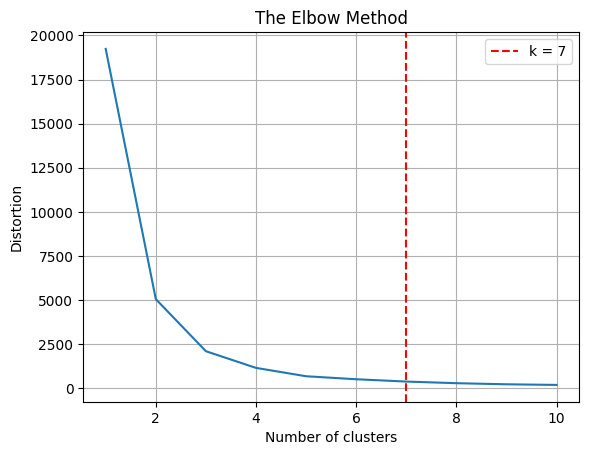

D:\anaconda3\envs\travel-time\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


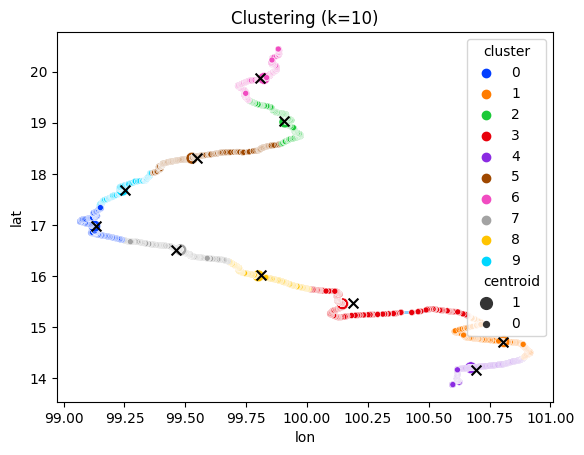

In [296]:
df_kmean = kmean(df_point, 1, 10)

In [297]:
get_kmean_value_counts(df_kmean)

4    1033
3     535
1     502
6     467
5     402
8     393
2     387
7     360
0     351
9     328
Name: cluster, dtype: int64


## Find stop time

In [6]:
df_gps = load_gps_data()

In [7]:
def find_stop_point(df_gps, rd):
    df_gps_tmp = df_gps.copy()
    df_road = pd.read_csv(road_data_dir + '/roaddb.csv')

    # preprocess df_road for find stop point
    df_road = df_road[df_road['rd'] == rd].reset_index(drop=True)
    df_road['coor'] = df_road.apply(lambda row: f"{row['latx']:.3f}, {row['lonx']:.3f}", axis=1)
    df_road = df_road.drop_duplicates(subset=['coor']).reset_index(drop=True)

    # preprocess df_gps for find stop point
    df_gps_tmp['coor'] = df_gps_tmp.apply(lambda row: f"{row['lat']:.3f}, {row['lon']:.3f}", axis=1)

    # find df_gps in select road 
    coor_lists = df_road['coor'].to_list()
    df_gps_tmp = df_gps_tmp[df_gps_tmp['coor'].isin(coor_lists)].reset_index(drop=True)

    # define stop detector
    stop_detector = StopDetector(df_gps_tmp)
    df_stop = stop_detector.get_stop_time_range(500, 300) # distance: 500 m, duration: 300 s
    
    # clear data in memory
    del df_gps_tmp

    return df_stop, df_road

In [21]:
df_stop, df_road = find_stop_point(df_gps, 304)

100%|██████████| 9679/9679 [06:51<00:00, 23.52it/s]


In [22]:
# savev dataframe
# df_stop.to_csv(os.path.join(stop_data_dir, 'df_stop_304.csv'))

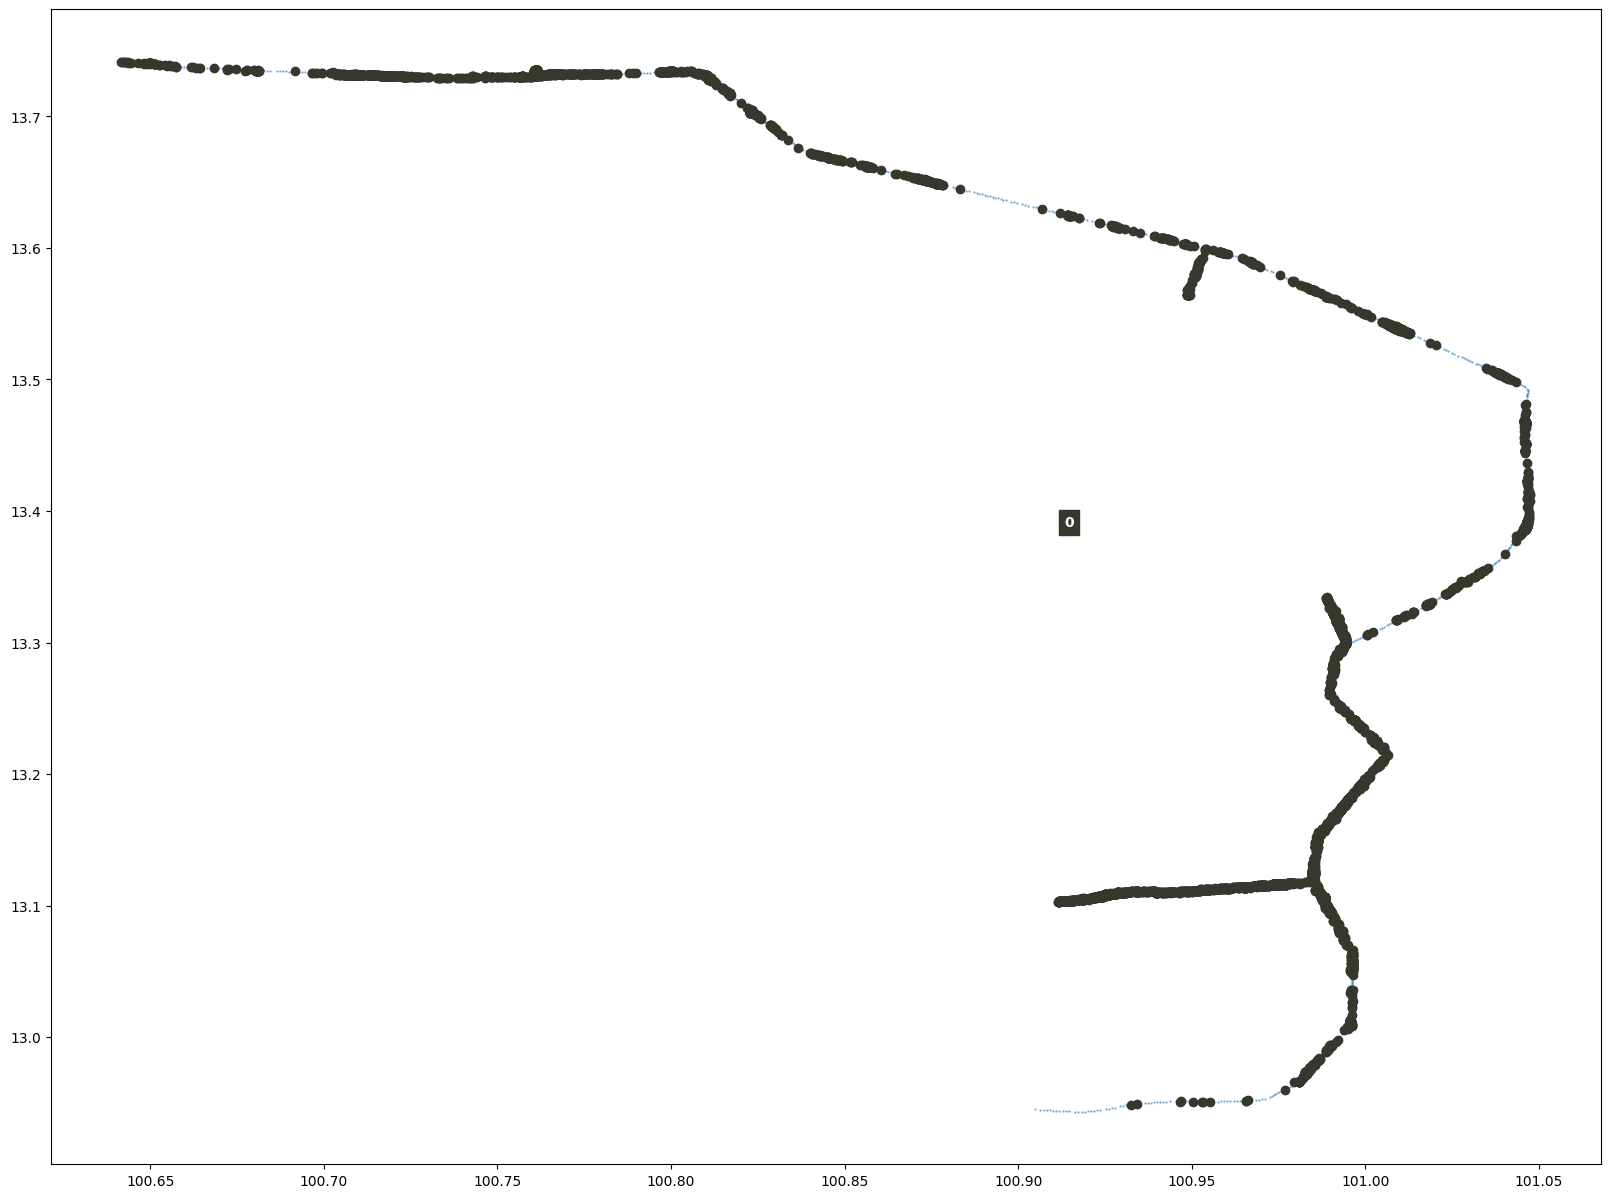

In [14]:
db = GPS_DBScan(df_stop, df_road)
db.dbscan(eps=0.1, min_samples=400)

## Find intersect uid

In [18]:
class FindIntersect:
    def __init__(self, df_gps):
        self.df_gps = df_gps
        self.df_road = None
        self.coor_road_lists = None
        self.intersect_lists = []

        # init dataframe gps for find intersect
        self.df_gps['coor'] = self.df_gps.apply(lambda row: f"{row['lat']:.3f}, {row['lon']:.3f}", axis=1)

    def set_raod_stop_point(self, rd, df_stop):
        self.df_stop = df_stop
        self.coor_road_lists = self._process_df_road(rd)

    def _process_df_road(self, rd):
        # get road dataframe
        self.df_road = get_road_data(rd)

        # clean dataframe
        self.df_road['coor'] = self.df_road.apply(lambda row: f"{row['latx']:.3f}, {row['lonx']:.3f}", axis=1)
        df_road = self.df_road.drop_duplicates(subset=['coor']).reset_index(drop=True)

        coor_lists = df_road['coor'].to_list()

        return coor_lists

    def find_intersect(self, cluster_start, cluster_stop):
        df_gps_tmp = self.df_gps[self.df_gps['coor'].isin(self.coor_road_lists)].reset_index(drop=True) 

        
        # init min max coor start value
        start_lat_lon, stop_lat_lon = self._process_lat_lon(cluster_start, cluster_stop)

        # start
        # condition filter start
        cond_lat_start = (df_gps_tmp['lat'] >= start_lat_lon[0]) & (df_gps_tmp['lat'] <= start_lat_lon[1])
        cond_lon_start = (df_gps_tmp['lon'] >= start_lat_lon[2]) & (df_gps_tmp['lon'] <= start_lat_lon[3])

        df_start_tmp = df_gps_tmp[cond_lat_start & cond_lon_start].reset_index(drop=True)
        uid_lists = list(set((df_start_tmp['unit_id'].to_list())))
        
        # stop
        # condition filter stop
        cond_lat_stop = (df_gps_tmp['lat'] >= stop_lat_lon[0]) & (df_gps_tmp['lat'] <= stop_lat_lon[1])
        cond_lon_stop = (df_gps_tmp['lon'] >= stop_lat_lon[2]) & (df_gps_tmp['lon'] <= stop_lat_lon[3])
        cond_uid_stop = df_gps_tmp['unit_id'].isin(uid_lists)

        df_intersect_tmp = df_gps_tmp[cond_lat_stop & cond_lon_stop & cond_uid_stop].reset_index(drop=True)
        uid_intersect_lists = list(set(df_intersect_tmp['unit_id'].to_list()))

        # clear data in memory
        del df_gps_tmp
        del df_start_tmp

        return df_intersect_tmp, uid_intersect_lists

    def _process_lat_lon(self, cluster_start, cluster_stop):
        lat_start, lon_start, lat_stop, lon_stop = self._process_centroid(cluster_start, cluster_stop)

        start_lat_lon = (lat_start - (0.5 * 0.01), lat_start + (0.5 * 0.01), lon_start - (0.5 * 0.01), lon_start + (0.5 * 0.01))
        stop_lat_lon = (lat_stop - (0.5 * 0.01), lat_stop + (0.5 * 0.01), lon_stop - (0.5 * 0.01), lon_stop + (0.5 * 0.01))

        return start_lat_lon, stop_lat_lon

    def find_intersect_all(self):
        self.intersect_lists = []
        label_lists = list(set(self.df_stop['label'].to_list()))
        for label_start in label_lists:
            for label_stop in label_lists:
                if label_start != label_stop:
                    _, uid_list = self.find_intersect(label_start, label_stop)
                    if len(uid_list) > 50:
                        self.intersect_lists.append(
                            {
                                'start_point': label_start,
                                'stop_point': label_stop,
                                'amount': len(uid_list),
                                'distance': self._process_distance(label_start, label_stop)
                            }
                        )

        self.intersect_lists = sorted(self.intersect_lists, key=lambda row: (row['distance'], row['amount']), reverse=True)

    def _process_distance(self, cluster_start, cluster_stop):
        lat_start, lon_start = self.df_stop.loc[self.df_stop['label'] == cluster_start, ['lat', 'lon']].mean()
        lat_stop, lon_stop = self.df_stop.loc[self.df_stop['label'] == cluster_stop, ['lat', 'lon']].mean()
        distance = math.sqrt(((lat_stop - lat_start) ** 2) + ((lon_stop - lon_start) ** 2))
        return distance

    def get_intersect_point(self):
        return self.intersect_lists

    def get_centroid_order(self, order):
        return self._process_centroid(self.intersect_lists[order - 1]['start_point'], self.intersect_lists[order - 1]['stop_point'])

    def _process_centroid(self, cluster_start, cluster_stop):
        lat_start, lon_start = self.df_stop.loc[self.df_stop['label'] == cluster_start, ['lat', 'lon']].mean()
        lat_stop, lon_stop = self.df_stop.loc[self.df_stop['label'] == cluster_stop, ['lat', 'lon']].mean()
        return lat_start, lon_start, lat_stop, lon_stop

    def show_start_stop(self, order):
        try:
            label_lists = list(set(self.df_stop['label'].to_list()))
            self._process_plot(self.intersect_lists[order - 1]['start_point'], self.intersect_lists[order - 1]['stop_point'], self.intersect_lists[order - 1]['amount'], self.intersect_lists[order - 1]['distance'] * 100, order, label_lists)
        except:
            print(f"Don't have intersect lists")
            
    def _process_plot(self, cluster_start, cluster_stop, amount, distance, order, labels):
        start_lat_lon, stop_lat_lon = self._process_lat_lon(cluster_start, cluster_stop)

        start = {
            'coor': (start_lat_lon[2], start_lat_lon[0]),
            'width': start_lat_lon[3] - start_lat_lon[2],
            'height': start_lat_lon[1] - start_lat_lon[0]
        }

        stop = {
            'coor': (stop_lat_lon[2], stop_lat_lon[0]),
            'width': stop_lat_lon[3] - stop_lat_lon[2],
            'height': stop_lat_lon[1] - stop_lat_lon[0]
        }

        fig, ax = plt.subplots(figsize=(20, 15))

        customPalette = ['#36382E', '#FF206E', '#E5C687', '#41EAD4', '#5C80BC', '#FB8B24', '#04A777', '#7E8D85', '#B3BFB8', '#6F8695']

        plt.scatter(
            x=self.df_road['lon'],
            y=self.df_road['lat'],
            s=0.5,
            alpha=0.5
        )

        for i, label in enumerate(labels):
            plt.scatter(
                x=self.df_stop[self.df_stop['label'] == label]['lon'],
                y=self.df_stop[self.df_stop['label'] == label]['lat'],
                color=customPalette[i % len(customPalette)],
                alpha=1
            )

            if label != cluster_start and label != cluster_stop:
                plt.annotate(
                    label,
                    self.df_stop.loc[self.df_stop['label'] == label, ['lon', 'lat']].mean(),
                    horizontalalignment='center',
                    verticalalignment='center',
                    size=10,
                    weight='bold',
                    color='white',
                    backgroundcolor=customPalette[i % len(customPalette)]
                )

        ax.add_patch(Rectangle(start['coor'], start['width'], start['height'], fc='none', color='red', linewidth=1))
        ax.text(start['coor'][0], start['coor'][1] + start['height'], f"start : {cluster_start}", color='red')
        ax.add_patch(Rectangle(stop['coor'], stop['width'], stop['height'], fc='none', color='blue', linewidth=1))
        ax.text(stop['coor'][0], stop['coor'][1] + stop['height'], f"stop : {cluster_stop}", color='blue')
        plt.title(f"order: {order} || cluster start: {cluster_start} || cluster stop: {cluster_stop} || distance: {distance} || amount: {amount}")
        plt.show()
        

In [7]:
df_gps = load_gps_data()

In [8]:
df_stop = pd.read_csv(os.path.join(stop_data_dir, 'df_stop_1.csv'))
df_road = get_road_data(1)

In [9]:
dbscan = GPS_DBScan(df_stop, df_road)

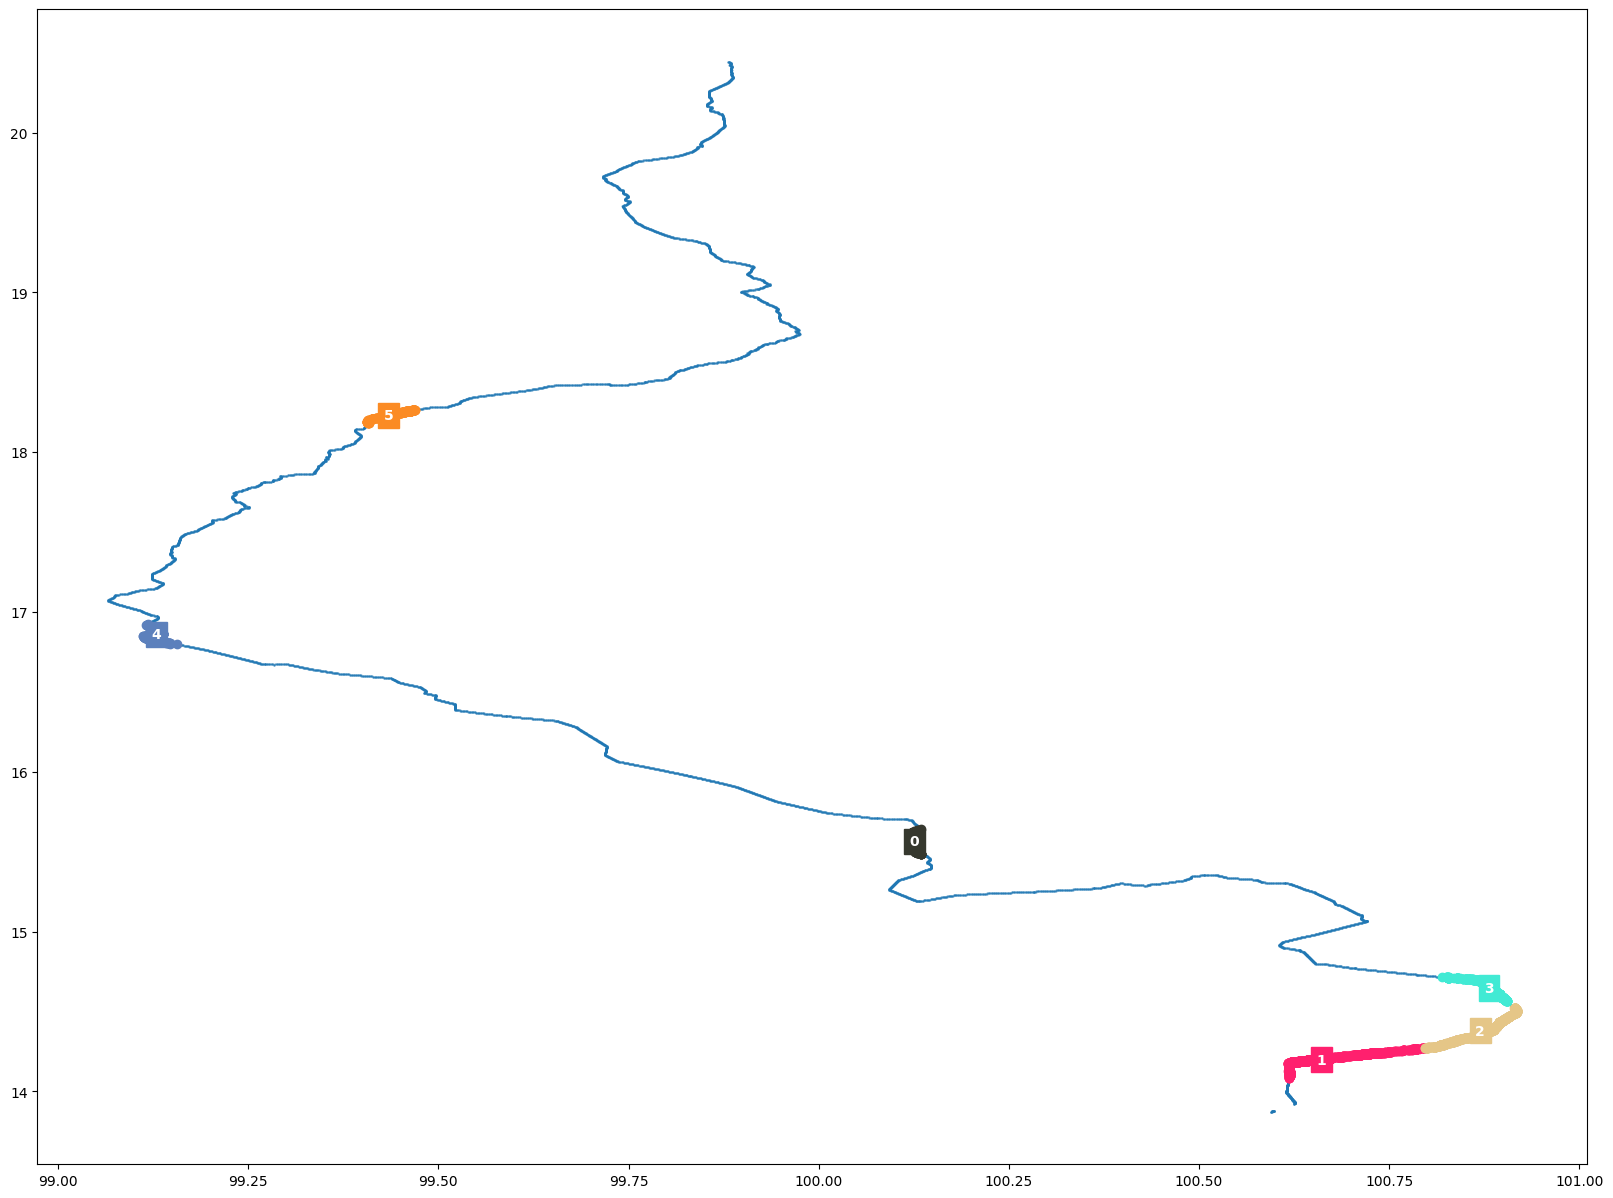

In [10]:
dbscan.dbscan(eps=0.05, min_samples=300)

In [11]:
df_label = dbscan.get_df()

In [12]:
df_label

unit_id        lat         lon           time_start  \
0     003000900000000011773901596  15.579176  100.124654  2019-03-01 16:01:15   
1     001000800000010882500000010  14.194746  100.645615  2019-03-01 12:00:48   
2     001000800000010882500000010  14.321001  100.839920  2019-03-01 14:07:42   
3     001000500000000112340107928  14.496723  100.916980  2019-03-01 19:03:02   
4     002000300000000000000514501  14.699682  100.860080  2019-03-01 05:36:07   
...                           ...        ...         ...                  ...   
4296  033000400000868998030633404  14.184270  100.626877  2019-03-01 17:03:24   
4297  006000500000868998030015354  18.189740   99.406690  2019-03-01 00:04:31   
4298  0290002-201803-00151-000003  16.842505   99.113170  2019-03-01 21:16:12   
4299  060000300000863835026169370  14.227501  100.709062  2019-03-01 00:04:50   
4300  002000300000000000000511786  15.559715  100.127475  2019-03-01 17:30:25   

                time_stop  label  
0     2019-03-01 17:13:35      0  
1     2019-03-01 12:40:46      1  
2     2019-03-01 15:15:40      2  
3     2019-03-01 19:21:20      2  
4     2019-03-01 08:40:09      3  
...                   ...    ...  
4296  2019-03-01 17:20:24      1  
4297  2019-03-01 01:08:34      5  
4298  2019-03-01 22:05:18      4  
4299  2019-03-01 04:04:50      1  
4300  2019-03-01 21:27:12      0  

[4301 rows x 6 columns]

In [19]:
find_intersect = FindIntersect(df_gps)

In [20]:
find_intersect.set_raod_stop_point(1, df_label)

In [21]:
# find uid dataframe and uid list from selected point
df_uid, uid_list = find_intersect.find_intersect(0, 5)
len(uid_list)

38

In [22]:
# find best point for intersect point on each road
find_intersect.find_intersect_all()

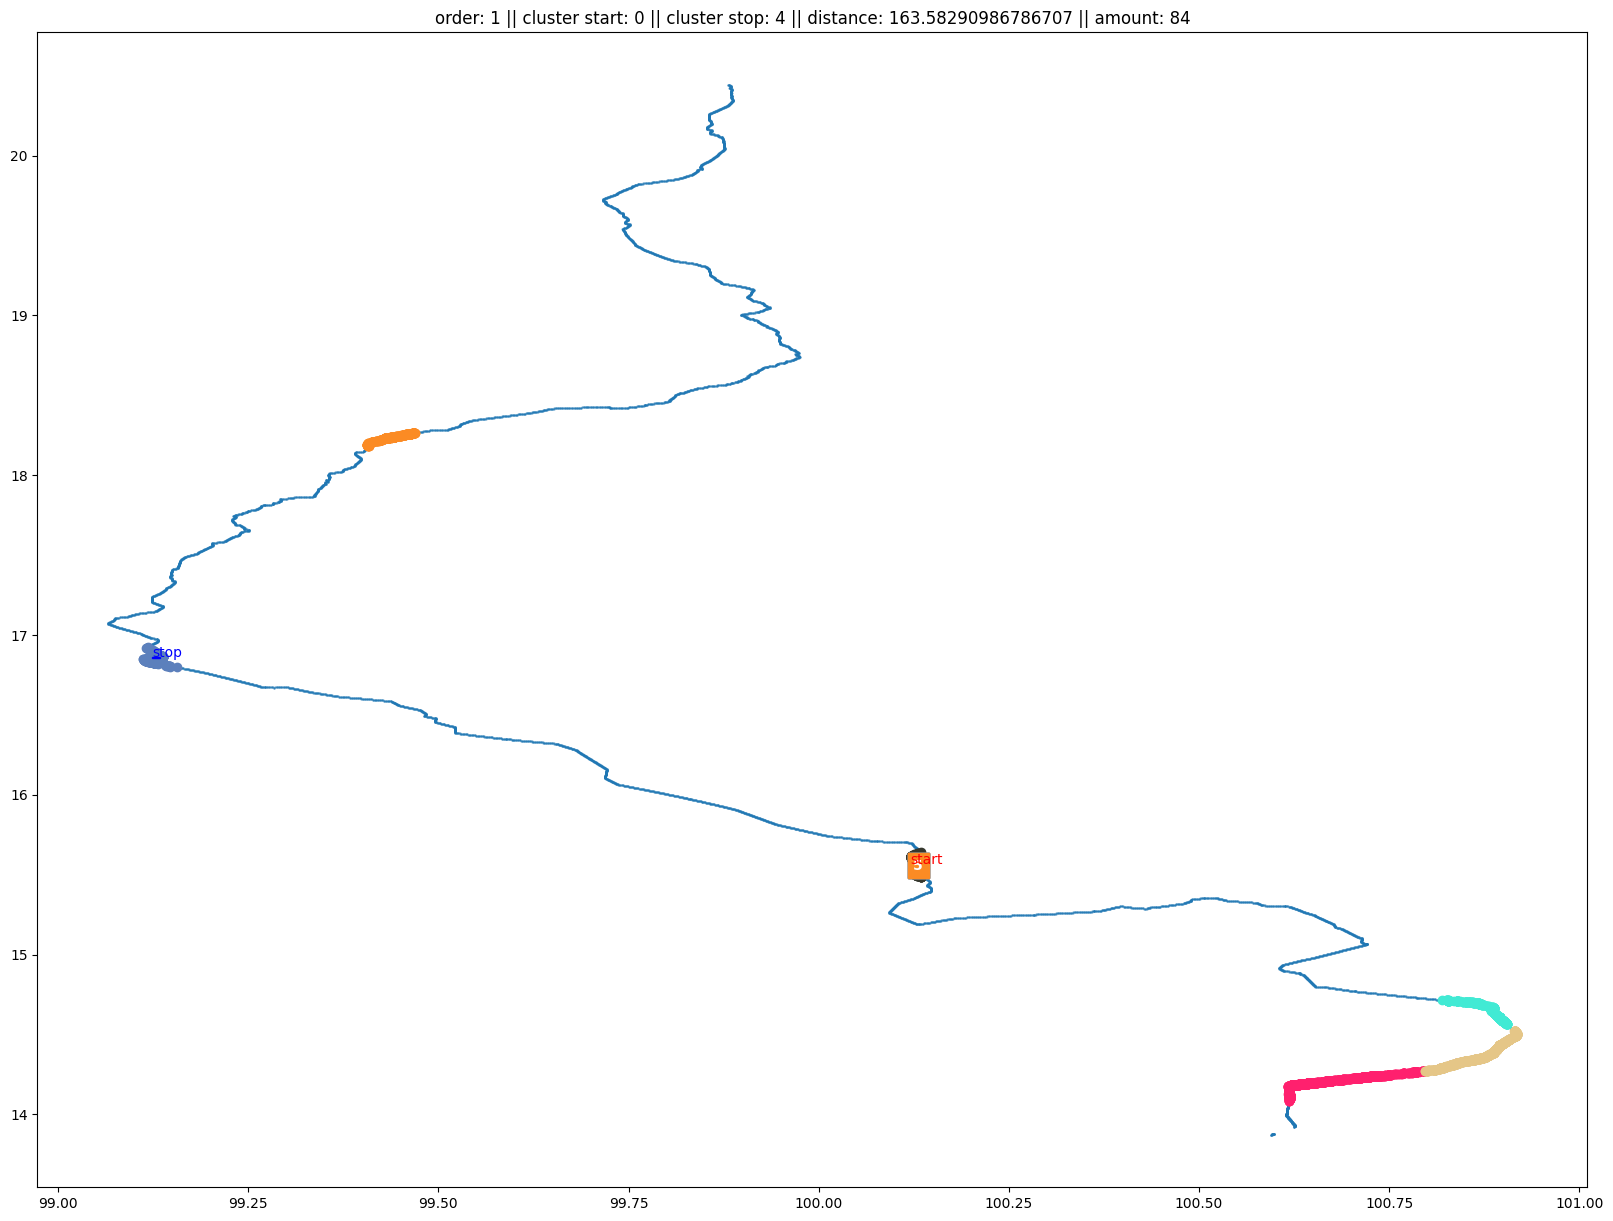

In [23]:
# show start and stop point by order
find_intersect.show_start_stop(1)